In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [17]:
# Converte os caminhos de string para objetos Path
DATA_PATH = Path('../data/sku_monthly_country_data.csv')
IMAGE_PATH = Path('../images')


In [18]:

# Configurar estilo de plotagem
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis') # Um conjunto de cores bonito para os gráficos

In [19]:
# 1. Carregar os dados
try:
    df_agg = pd.read_csv(DATA_PATH)
    print(f"Dados agregados carregados com sucesso. Total de {len(df_agg)} linhas.\n")

    # Converter 'InvoiceYearMonth' de volta para datetime para séries temporais
    df_agg['InvoiceYearMonth'] = pd.to_datetime(df_agg['InvoiceYearMonth'])

    # Ordenar os dados para garantir que a série temporal esteja correta
    df_agg.sort_values(by=['StockCode', 'Country', 'InvoiceYearMonth'], inplace=True)

    print("Primeiras 5 linhas do DataFrame agregado:\n")
    display(df_agg.head()) # Usar display() em notebooks para uma saída mais formatada
    print(f"\nColunas do DataFrame e seus tipos de dados:\n")
    df_agg.info()

except FileNotFoundError:
    print(f"Erro: O arquivo de dados agregados '{DATA_PATH}' não foi encontrado.")
    print("Por favor, certifique-se de que 'create_ecommerce_db.py' e 'prepare_data_for_modeling.py' foram executados e o CSV foi gerado corretamente na pasta 'data/'.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar os dados: {e}")


Dados agregados carregados com sucesso. Total de 66779 linhas.

Primeiras 5 linhas do DataFrame agregado:



,StockCode,InvoiceYearMonth,Country,total_quantity,avg_price_monthly
0,10002,2010-12-01,EIRE,12,0.85
1,10002,2010-12-01,France,96,0.85
2,10002,2011-01-01,France,156,0.85
3,10002,2011-04-01,France,120,0.85
4,10002,2011-01-01,Germany,1,0.85



Colunas do DataFrame e seus tipos de dados:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66779 entries, 0 to 66778
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   StockCode          66779 non-null  object        
 1   InvoiceYearMonth   66779 non-null  datetime64[ns]
 2   Country            66779 non-null  object        
 3   total_quantity     66779 non-null  int64         
 4   avg_price_monthly  66779 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.5+ MB


In [20]:
# Certifique-se de que df_agg foi carregado com sucesso antes de prosseguir
if 'df_agg' in locals() and df_agg is not None and not df_agg.empty:
    print("\nIniciando a análise e visualização das alterações de preço (versão FINAL e completa)...\n")

    # Calcular a variação de preço para cada SKU/País ao longo do tempo
    df_agg['price_change'] = df_agg.groupby(['StockCode', 'Country'])['avg_price_monthly'].diff()
    df_agg['price_change_abs'] = df_agg['price_change'].abs() # Magnitude da mudança

    # Inicializar dicionários para categorizar SKUs por país
    skus_with_price_changes_by_country = {}
    skus_without_price_changes_by_country = {}
    skus_with_insufficient_data_by_country = {}

    all_unique_skus = df_agg['StockCode'].unique()

    for sku in all_unique_skus:
        sku_data = df_agg[df_agg['StockCode'] == sku]
        countries_in_sku = sku_data['Country'].unique()
        for country in countries_in_sku:
            country_sku_data = sku_data[sku_data['Country'] == country].copy()
            
            if len(country_sku_data) > 1:
                if not country_sku_data['price_change'].dropna().eq(0).all():
                    if sku not in skus_with_price_changes_by_country:
                        skus_with_price_changes_by_country[sku] = []
                    skus_with_price_changes_by_country[sku].append(country)
                else:
                    if sku not in skus_without_price_changes_by_country:
                        skus_without_price_changes_by_country[sku] = []
                    skus_without_price_changes_by_country[sku].append(country)
            else:
                if sku not in skus_with_insufficient_data_by_country:
                    skus_with_insufficient_data_by_country[sku] = []
                skus_with_insufficient_data_by_country[sku].append(country)


    print(f"Total de SKUs únicos analisados: {len(all_unique_skus)}\n")
    print(f"Total de SKUs com pelo menos uma alteração de preço registrada (contando por SKU): {len(skus_with_price_changes_by_country)}\n")
    print(f"Total de SKUs sem alteração de preço (mas com dados suficientes em pelo menos um país): {len(skus_without_price_changes_by_country)}\n")
    print(f"Total de SKUs com dados insuficientes para análise de série temporal em pelo menos um país: {len(skus_with_insufficient_data_by_country)}\n")
    
    print("Exemplo de SKUs com alteração de preço por país (primeiros 5):")
    for sku, countries in list(skus_with_price_changes_by_country.items())[:5]:
        print(f"  SKU: {sku}, Países: {countries}")
    if len(skus_with_price_changes_by_country) > 5: print("  ...\n")
    else: print("\n")

    print("Exemplo de SKUs sem alteração de preço por país (primeiros 5):")
    for sku, countries in list(skus_without_price_changes_by_country.items())[:5]:
        print(f"  SKU: {sku}, Países: {countries}")
    if len(skus_without_price_changes_by_country) > 5: print("  ...\n")
    else: print("\n")
    
    print("Exemplo de SKUs com dados insuficientes por país (primeiros 5):")
    for sku, countries in list(skus_with_insufficient_data_by_country.items())[:5]:
        print(f"  SKU: {sku}, Países: {countries}")
    if len(skus_with_insufficient_data_by_country) > 5: print("  ...\n")
    else: print("\n")


    # --- Novas Visualizações Agregadas e Análises (com escalas log/symlog e salvamento de imagens) ---

    # Filtrar apenas os dados onde houve mudança de preço para as análises de distribuição
    df_changes = df_agg[df_agg['price_change'].notna() & (df_agg['price_change'] != 0)].copy()

    if not df_changes.empty:
        print("Análise de distribuição das alterações de preço (e salvando imagens com escalas ajustadas)...\n")

        # 1. Histograma da magnitude das alterações de preço (Y-axis em escala logarítmica)
        plt.figure(figsize=(10, 6))
        sns.histplot(df_changes['price_change_abs'], bins=50, kde=True, log_scale=(False, True)) # log_scale=(x, y)
        plt.title('Distribuição da Magnitude Absoluta das Alterações de Preço (Escala Log na Frequência)')
        plt.xlabel('Magnitude da Alteração de Preço')
        plt.ylabel('Frequência (Escala Log)')
        plt.savefig(IMAGE_PATH / 'dist_magnitude_price_changes_log_freq.png')
        plt.close()

        # 2. Histograma da direção e magnitude das alterações de preço (X-axis em escala symlog, Y-axis em escala log)
        plt.figure(figsize=(10, 6))
        sns.histplot(df_changes['price_change'], bins=50, kde=True, log_scale=(False, True)) # log_scale=(x, y)
        plt.xscale('symlog', linthresh=0.01) # linthresh define a região linear em torno de zero
        plt.title('Distribuição da Direção e Magnitude das Alterações de Preço (Symlog no Preço, Log na Frequência)')
        plt.xlabel('Alteração de Preço (Positiva: Aumento, Negativa: Redução) (Escala Symlog)')
        plt.ylabel('Frequência (Escala Log)')
        plt.savefig(IMAGE_PATH / 'dist_direction_price_changes_symlog_log.png')
        plt.close()

        # 3. Boxplot das alterações de preço por País (Y-axis em escala symlog)
        top_countries_by_changes = df_changes['Country'].value_counts().head(5).index.tolist()
        if top_countries_by_changes:
            plt.figure(figsize=(12, 7))
            sns.boxplot(data=df_changes[df_changes['Country'].isin(top_countries_by_changes)], 
                        x='Country', y='price_change', hue='Country', legend=False, palette='viridis')
            plt.yscale('symlog', linthresh=0.01) # linthresh define a região linear em torno de zero
            plt.title('Distribuição das Alterações de Preço por Top 5 Países (Escala Symlog)')
            plt.xlabel('País')
            plt.ylabel('Alteração de Preço (Escala Symlog)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(IMAGE_PATH / 'boxplot_price_changes_by_country_symlog.png')
            plt.close()
        else:
            print("Não há países suficientes com alterações de preço para gerar o Boxplot.\n")


        # Identificar os SKUs com as maiores variações de preço (em termos absolutos)
        sku_country_total_abs_change = df_changes.groupby(['StockCode', 'Country'])['price_change_abs'].sum().reset_index()
        top_n_changes = sku_country_total_abs_change.nlargest(10, 'price_change_abs')
        print("\nTop 10 SKU-País com as maiores somas de magnitude de alterações de preço:\n")
        display(top_n_changes)

        # Loop para salvar os gráficos dos top SKUs (com escalas log/symlog se necessário para o preço)
        if len(top_n_changes) > 0:
            print("\nSalvando gráficos dos top SKUs com maiores variações de preço...\n")
            for index, row in top_n_changes.iterrows():
                top_sku = row['StockCode']
                top_country = row['Country']
                plot_data = df_agg[(df_agg['StockCode'] == top_sku) & (df_agg['Country'] == top_country)].copy()
                if len(plot_data) > 1:
                    plt.figure(figsize=(12, 6))
                    sns.lineplot(data=plot_data, x='InvoiceYearMonth', y='avg_price_monthly', marker='o')
                    
                    # Adicionar escala symlog ao eixo Y para os plots individuais se os preços variarem muito e se concentrarem perto de 0
                    # Você pode ajustar o `linthresh` conforme a sua necessidade para o "zero"
                    # A condição abaixo é um exemplo; você pode remover ou ajustar se souber o comportamento dos seus preços
                    if plot_data['avg_price_monthly'].max() - plot_data['avg_price_monthly'].min() > 100 and \
                       plot_data['avg_price_monthly'].min() < 1: # Preços com grande variação e que passam perto de zero
                        plt.yscale('symlog', linthresh=0.01)
                    
                    plt.title(f'Variação do Preço Médio Mensal para SKU: {top_sku} - País: {top_country}')
                    plt.xlabel('Mês')
                    plt.ylabel('Preço Médio Ponderado Mensal')
                    plt.xticks(rotation=45)
                    plt.grid(True)
                    plt.tight_layout()
                    plt.savefig(IMAGE_PATH / f'price_variation_sku_{top_sku}_country_{top_country}.png')
                    plt.close()
                else:
                    print(f"Dados insuficientes para plotar o SKU: {top_sku} - País: {top_country}.\n")
        else:
            print("Não há alterações de preço suficientes para plotar os top SKUs.\n")


    else:
        print("Nenhuma alteração de preço detectada nos dados para análise de distribuição.\n")
else:
    print("DataFrame 'df_agg' não carregado ou está vazio. Não foi possível realizar a análise.\n")


Iniciando a análise e visualização das alterações de preço (versão FINAL e completa)...

Total de SKUs únicos analisados: 3922

Total de SKUs com pelo menos uma alteração de preço registrada (contando por SKU): 3393

Total de SKUs sem alteração de preço (mas com dados suficientes em pelo menos um país): 1912

Total de SKUs com dados insuficientes para análise de série temporal em pelo menos um país: 2929

Exemplo de SKUs com alteração de preço por país (primeiros 5):
  SKU: 10002, Países: ['United Kingdom']
  SKU: 10080, Países: ['United Kingdom']
  SKU: 10125, Países: ['France', 'Germany', 'United Kingdom']
  SKU: 10133, Países: ['Canada', 'United Kingdom']
  SKU: 10135, Países: ['United Kingdom']
  ...

Exemplo de SKUs sem alteração de preço por país (primeiros 5):
  SKU: 10002, Países: ['France']
  SKU: 10120, Países: ['United Kingdom']
  SKU: 10123C, Países: ['United Kingdom']
  SKU: 10124A, Países: ['United Kingdom']
  SKU: 10124G, Países: ['United Kingdom']
  ...

Exemplo de SKU

,StockCode,Country,price_change_abs
5478,AMAZONFEE,United Kingdom,13321.570000
5488,M,France,9424.470000
5510,POST,United Kingdom,8254.745000
5490,M,Hong Kong,2398.040000
5492,M,Singapore,1815.862000
5486,DOT,United Kingdom,1532.872376
5506,POST,Norway,1332.636364
5491,M,Portugal,743.715000
5489,M,Germany,738.490000
5487,M,EIRE,462.063333



Salvando gráficos dos top SKUs com maiores variações de preço...



In [21]:
# Certifique-se de que a célula anterior com a criação dos dicionários foi executada

# 1. Transformar o dicionário 'skus_with_price_changes_by_country' em uma lista de tuplas (StockCode, Country)
#    Estas são as combinações SKU-País que tiveram alterações de preço e, portanto, são relevantes para o treinamento.
eligible_sku_country_pairs = []
for sku, countries in skus_with_price_changes_by_country.items():
    for country in countries:
        eligible_sku_country_pairs.append((sku, country))

# Converter para um conjunto para otimizar a performance da verificação (lookup é mais rápido em sets)
eligible_sku_country_pairs_set = set(eligible_sku_country_pairs)

# 2. Filtrar o df_agg
#    Crie uma coluna temporária para as combinações (StockCode, Country) no df_agg
df_agg['sku_country_pair'] = list(zip(df_agg['StockCode'], df_agg['Country']))

#    Usando o método .isin() para filtrar as linhas desejadas
df_for_training = df_agg[df_agg['sku_country_pair'].isin(eligible_sku_country_pairs_set)].copy()

# 3. Remover a coluna temporária 'sku_country_pair'
df_for_training.drop(columns=['sku_country_pair'], inplace=True)

print(f"DataFrame 'df_for_training' criado com sucesso!")
print(f"Número de linhas (SKU-Mês-País) para treinamento: {len(df_for_training)}\n")
print("Primeiras 5 linhas do DataFrame 'df_for_training':\n")
display(df_for_training.head())
print("\nInformações do DataFrame 'df_for_training':\n")
df_for_training.drop(columns= 'price_change_abs', inplace= True)
df_for_training.info()


DataFrame 'df_for_training' criado com sucesso!
Número de linhas (SKU-Mês-País) para treinamento: 41687

Primeiras 5 linhas do DataFrame 'df_for_training':



,StockCode,InvoiceYearMonth,Country,total_quantity,avg_price_monthly,price_change,price_change_abs
8,10002,2010-12-01,United Kingdom,143,0.997273,NaN,NaN
9,10002,2011-01-01,United Kingdom,147,0.866122,-0.131150,0.131150
10,10002,2011-02-01,United Kingdom,51,0.880588,0.014466,0.014466
11,10002,2011-03-01,United Kingdom,28,0.989286,0.108697,0.108697
12,10002,2011-04-01,United Kingdom,69,0.850000,-0.139286,0.139286



Informações do DataFrame 'df_for_training':

<class 'pandas.core.frame.DataFrame'>
Index: 41687 entries, 8 to 66777
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   StockCode          41687 non-null  object        
 1   InvoiceYearMonth   41687 non-null  datetime64[ns]
 2   Country            41687 non-null  object        
 3   total_quantity     41687 non-null  int64         
 4   avg_price_monthly  41687 non-null  float64       
 5   price_change       36171 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 2.2+ MB


<Figure size 1000x600 with 0 Axes>

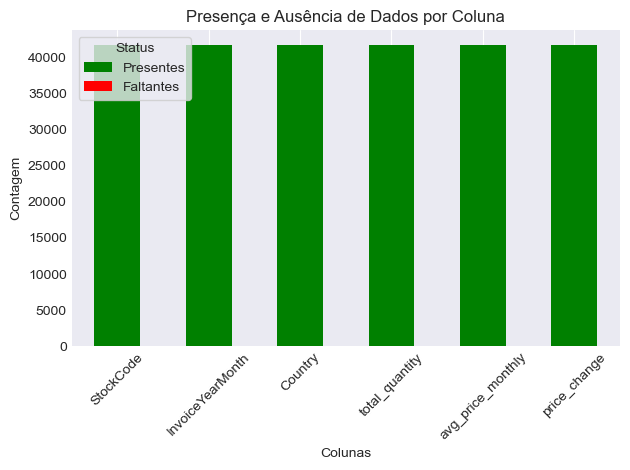

In [26]:
# Cálculo da quantidade de valores presentes e ausentes por coluna
present_count = df_for_training.notna().sum()
missing_count = df_for_training.isna().sum()

# Empilhando os dados em um DataFrame para facilitar o plot
stacked_data = pd.DataFrame({
    'Presentes': present_count,
    'Faltantes': missing_count
})

# Geração do gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
stacked_data.plot(kind='bar', stacked=True, color=['green', 'red'])

plt.title('Presença e Ausência de Dados por Coluna')
plt.ylabel('Contagem')
plt.xlabel('Colunas')
plt.xticks(rotation=45)

# Ajuste na legenda com fundo visível
plt.legend(title='Status', frameon=True, loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(IMAGE_PATH / 'missing_data.png')
plt.show()

In [27]:
df_for_training = df_for_training.fillna(0)

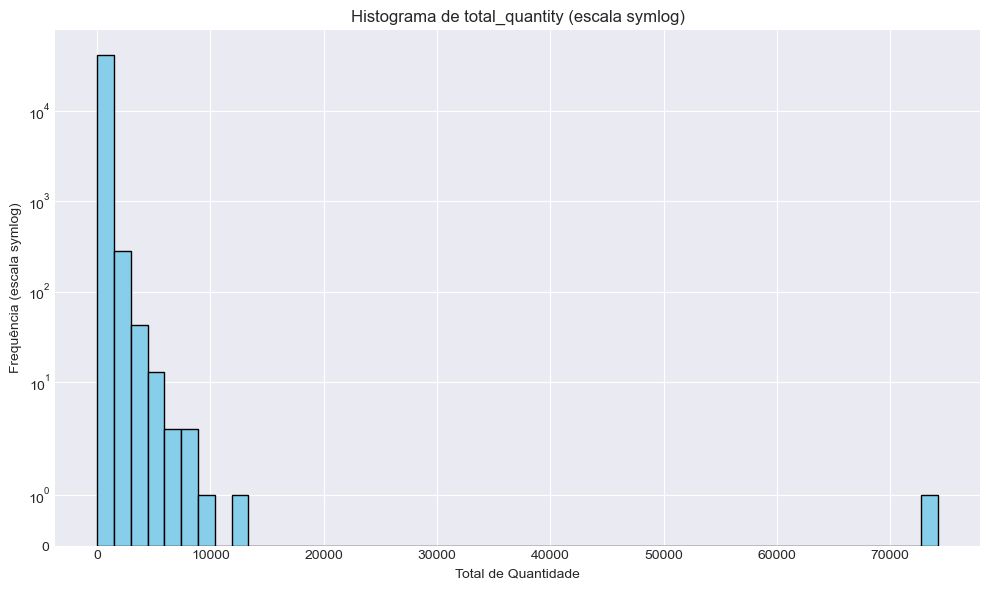

In [28]:
# Geração do histograma com escala symlog
plt.figure(figsize=(10, 6))
plt.hist(df_for_training["total_quantity"], bins=50, color='skyblue', edgecolor='black')
plt.yscale('symlog')
plt.title('Histograma de total_quantity (escala symlog)')
plt.xlabel('Total de Quantidade')
plt.ylabel('Frequência (escala symlog)')
plt.grid(True)
plt.tight_layout()
plt.savefig(IMAGE_PATH/ 'histograma_total_quantity.png')
plt.show()

In [29]:
df_for_training["log_total_quantity"] = df_for_training["total_quantity"].apply(lambda x: np.log1p(x))

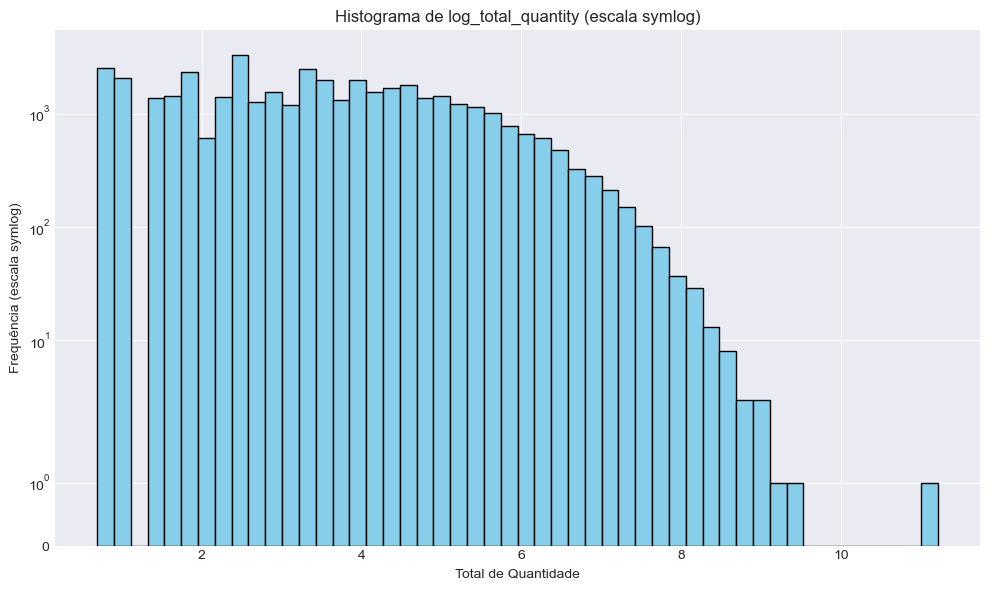

In [30]:
# Geração do histograma com escala symlog
plt.figure(figsize=(10, 6))
plt.hist(df_for_training["log_total_quantity"], bins=50, color='skyblue', edgecolor='black')
plt.yscale('symlog')
plt.title('Histograma de log_total_quantity (escala symlog)')
plt.xlabel('Total de Quantidade')
plt.ylabel('Frequência (escala symlog)')
plt.grid(True)
plt.tight_layout()
plt.savefig(IMAGE_PATH)
plt.show()

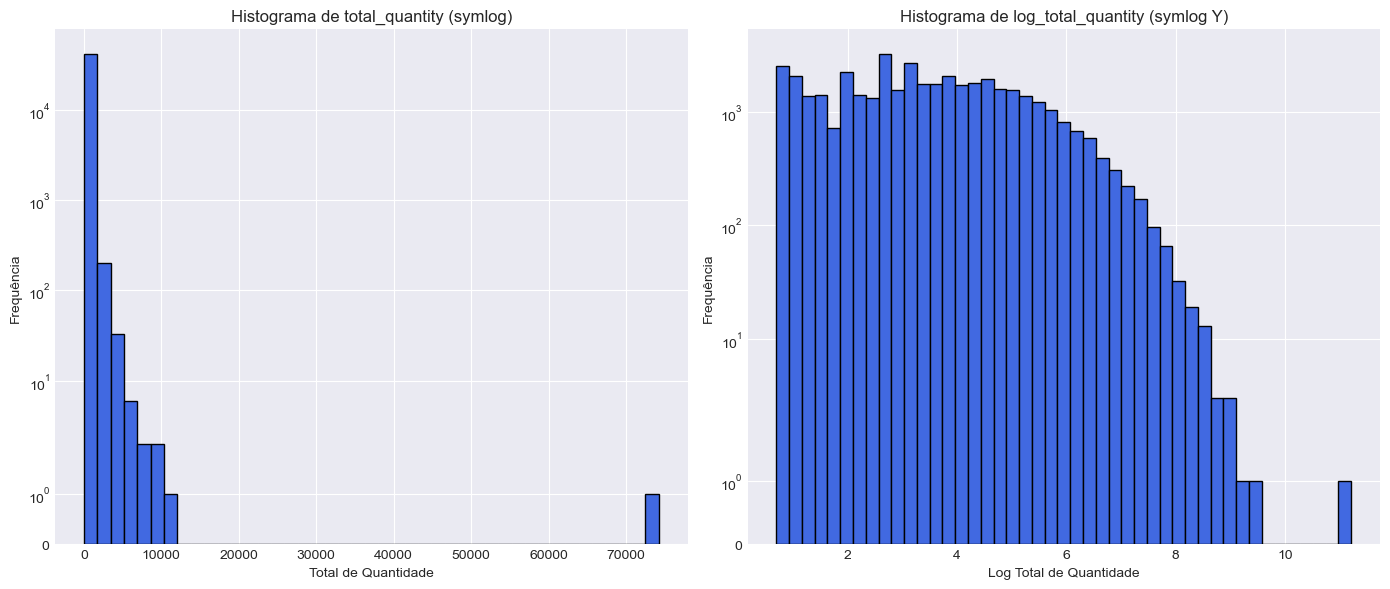

In [31]:
# Redefinindo caminho de salvamento conjunto
COMBINED_IMAGE_PATH = IMAGE_PATH / 'subplots_total_quantity_comparativo.png'

# Criação da figura com dois subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histograma de total_quantity com escala symlog nos eixos X e Y
axs[0].hist(df_for_training["total_quantity"].dropna(), bins=43, color='royalblue', edgecolor='black')
axs[0].set_yscale('symlog')
axs[0].set_title('Histograma de total_quantity (symlog)')
axs[0].set_xlabel('Total de Quantidade')
axs[0].set_ylabel('Frequência')
axs[0].grid(True)

# Histograma de log_total_quantity com escala symlog em Y
axs[1].hist(df_for_training["log_total_quantity"].dropna(), bins=45, color='royalblue', edgecolor='black')
axs[1].set_yscale('symlog')
axs[1].set_title('Histograma de log_total_quantity (symlog Y)')
axs[1].set_xlabel('Log Total de Quantidade')
axs[1].set_ylabel('Frequência')
axs[1].grid(True)

plt.tight_layout()
plt.savefig(COMBINED_IMAGE_PATH)
plt.show()

In [32]:
OUTPUT_TRAINING_CSV_PATH = Path('../data/df_for_training.csv') 
df_for_training.to_csv(OUTPUT_TRAINING_CSV_PATH, index=False)
print(f"\nDataFrame para treinamento salvo em '{OUTPUT_TRAINING_CSV_PATH}'.")


DataFrame para treinamento salvo em '..\data\df_for_training.csv'.
